In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

In [4]:
!wget $data -O homework-week-3.csv

--2022-10-04 20:51:35--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘homework-week-3.csv’

homework-week-3.csv 100%[===================>]  71.53K   129KB/s    in 0.6s    

2022-10-04 20:51:37 (129 KB/s) - ‘homework-week-3.csv’ saved [73250/73250]



In [3]:
df = pd.read_csv('homework-week-3.csv')
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
card,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
reports,0,0,0,0,0,0,0,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667,23.25,27.91667,29.16667,37.0,28.41667
income,4.52,2.42,4.5,2.54,9.7867,2.5,3.96,2.37,3.8,3.2
share,0.03327,0.005217,0.004156,0.065214,0.067051,0.044438,0.012576,0.076434,0.245628,0.01978
expenditure,124.9833,9.854167,15.0,137.8692,546.5033,91.99667,40.83333,150.79,777.8217,52.58
owner,yes,no,yes,no,yes,no,no,yes,yes,no
selfemp,no,no,no,no,no,no,no,no,no,no
dependents,3,3,4,0,2,0,2,0,0,0
months,54,34,58,25,64,54,7,77,97,65


In [4]:
df.shape

(1319, 12)

In [5]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [6]:
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

# Preparation

In [7]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [8]:
df.card = (df.card == 'yes').astype(int)
df.owner = (df.owner == 'yes').astype(int)
df.selfemp = (df.selfemp == 'yes').astype(int)

In [9]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [16]:
columns = ['reports', 'age', 'income', 'share', 'expenditure', 'owner', 'selfemp', 'dependents', 'months', 'majorcards', 'active']

In [11]:
df.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner            int64
selfemp          int64
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [12]:
# split into 3 parts using train_test_split
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

In [15]:
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. '-df_train['expenditure']')

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- reports
- dependents
- active
- share

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [24]:
for col in columns:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print('%9s, %.3f' % (col, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
    owner, 0.586
  selfemp, 0.510
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


## Training the model
From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [28]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [29]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

## Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [31]:
roc_auc_score(y_val, y_pred).round(3)

0.995

## Question 3
Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
At which threshold precision and recall curves intersect?

In [51]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [52]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,206,6,5,47
30,0.3,205,3,6,50
40,0.4,204,1,7,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


In [53]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

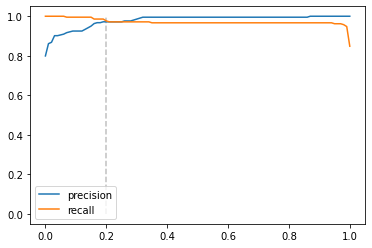

In [54]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.2, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

## Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both


Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

In [55]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

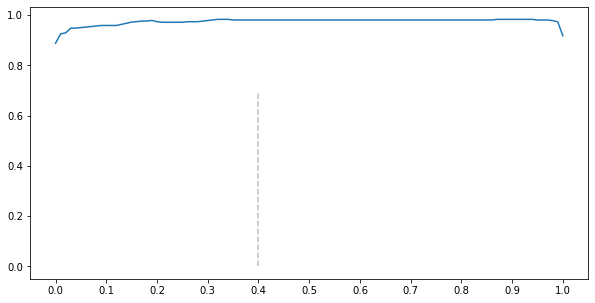

In [58]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.4, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

## Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation
How large is standard devidation of the AUC scores across different folds?

In [60]:
from sklearn.model_selection import KFold

In [63]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [64]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


## Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?



In [65]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.994 +- 0.005
C=   1, 0.996 +- 0.003
C=  10, 0.997 +- 0.003
